# Companion code for Asymptotics of weighted reflectable walks in $A_2$ \(extended abstract\)

### Torin Greenwood

### Samuel Simon


This worksheet takes the Tandem stepset and computes the critical points and the asymptotics at each critical point.

## Step 1: Expressing the walks as the diagonal of a rational generating function.

The following code block is from Steve Melczer's book, An Invitation to Analytic Combinatorics.
Code available online: [https://melczer.ca/files/TextbookCode/Chapter4/Example4\-3\-5\-6\-GeneratingWalkGroupsAndGFs.html](https://melczer.ca/files/TextbookCode/Chapter4/Example4-3-5-6-GeneratingWalkGroupsAndGFs.html)



In [3]:
# Enter the short step sets defining quadrant models with finite group
N = (0,1); SS = (0,-1); E = (1,0); W = (-1,0);
NE = (1,1); NW = (-1,1); SE = (1,-1); SW = (-1,-1);

# Define functions to plot a step set, generate the group, orbit sum, and diagonal expression for a walk
var('x,y,t,X,Y,a,b')

# Plot a step set S
def plot_steps(S):
    pt = sum([arrow((0,0),s) for s in S])
    pt.set_aspect_ratio(1)
    return pt

# Generate the group of a walk (up to a fixed number of elements)
def genGP(ST):
    # Get the characteristic polynomial of the model
    S = sum([X^i*Y^j for [i,j] in ST])

    # Define the rational maps for the lattice path model
    Am1 = S.coefficient(Y,-1);  A0 = S.coefficient(Y,0);  A1 = S.coefficient(Y,1)
    Bm1 = S.coefficient(X,-1);  B0 = S.coefficient(X,0);  B1 = S.coefficient(X,1)
    def Ψ(SS): return [L.subs(X=SS[0],Y=SS[1]).simplify() for L in [(1/X)*Bm1/B1,Y]]
    def Φ(SS): return [L.subs(X=SS[0],Y=SS[1]).simplify() for L in [X,(1/Y)*Am1/A1]]

    # Keep applying the maps until the set stabilizes or gets larger than a fixed bound
    List = [ ([],[x,y]) ]
    N = -1
    while (N != len(List)) and (len(List) < 10):
        N = len(List)
        for i in List:
            newI = true
            newP = true

            t2I = [k.simplify_full() for k in Ψ(i[1])]
            t2P = [k.simplify_full() for k in Φ(i[1])]

            for k in List:
                if k[1] == t2I:
                    newI = false
                if k[1] == t2P:
                    newP = false
                if not (newI or newP):
                    break

            if newI:
                List = List + [(['Ψ'] + i[0],t2I)]
            if newP:
                List = List + [(['Φ'] + i[0],t2P)]
            if len(List) >= 10:
                break

    if len(List) >= 10:
         print("Warning: Group size is larger than test bound, and may be infinite")
    return List

# Get orbit sum
def OrbitSum(ST):
    K = 1-t*add([x^i*y^j for [i,j] in ST])
    LST = genGP(ST)

    # Sum the Kernel Equation after it's acted upon by the group elements
    function('F')(Y)
    function('G')(X)
    function('Q')(X,Y)
    var('Kk')

    EQ = Kk*X*Y*Q(X,Y) == X*Y + F(Y) + G(X)
    orb_eq = add([EQ.substitute(X=k[0],Y=k[1])*(-1)^len(i) for [i,k] in LST]).simplify()

    # Return the right-hand side after dividing by the kernel
    orb_sum = (orb_eq.rhs()/(K*x*y)).factor()
    return orb_sum

# Convert orbit sum into rational diagonal expression
def RatDiag(ST):
    return (OrbitSum(ST).subs(x=1/x,y=1/y,t=x*y*t)/(1-x)/(1-y)).factor()

In [4]:
# We'll also use a weighted version:
def WeightedRatDiag(ST):
    return (OrbitSum(ST).subs(x=a/x,y=b/y,t=x*y*t)/(1-x)/(1-y)).factor()

### Computing the GF:



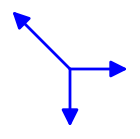

(b^2*x - a*y^2)*(b*x^2 - a^2*y)*(a*b - x*y)/((b^2*t*x^2 + a^2*b*t*y + a*t*x*y^2 - a*b)*a^2*b^2*(x - 1)*x*(y - 1)*y)


In [5]:
# Now, to compute the GF for the Tandem model:
steps = [E,NW,SS]
show(plot_steps(steps),figsize=2, axes=false)
OrbitSum(steps)
print(WeightedRatDiag(steps))

In [6]:
G = (b^2*x - a*y^2)*(b*x^2 - a^2*y)*(a*b - x*y)
H = ((b^2*t*x^2 + a^2*b*t*y + a*t*x*y^2 - a*b)*a^2*b^2*(x - 1)*x*(y - 1)*y)

## Step 2: Finding Critical Points



We again borrow code from Steve Melczer's book to compute critical points and smooth asymptotics.
The code is available online here:
https://melczer.ca/files/TextbookCode/Chapter5/Example5-SmoothASM.html

In [7]:
# Set a parameter to help simplify some algebraic numbers
maxima_calculus('algebraic: true;')

# Procedure to get Hessian appearing in asymptotics
# Input: H, member of the symbolic ring
#        r, direction vector (which can contain symbolic entries)
#        vars, vector of variables
#        CP, a dictionary mapping elements of vars
# Output: The Hessian H defined in Lemma 5.5 of the textbook at the point w defined by CP
def getHes(H,r,vars,CP):
    dd = len(vars)
    V = zero_vector(SR,dd)
    U = matrix(SR,dd)
    M = matrix(SR,dd-1)

    for j in range(dd):
        V[j] = r[j]/r[-1]
        for i in range(dd):
            U[i,j] = vars[i]*vars[j]*diff(H,vars[i],vars[j])/vars[-1]/diff(H,vars[-1])
    for i in range(dd-1):
        for j in range(dd-1):
            M[i,j] = V[i]*V[j] + U[i,j] - V[j]*U[i,-1] - V[i]*U[j,-1] + V[i]*V[j]*U[-1,-1]
            if i == j: M[i,j] = M[i,j] + V[i]
    return M(CP)

# Procedure to apply differential operator to f and set all variables to zero
# Input: dop, element of a DifferentialWeylAlgebra over a polynomial ring
#        f, an element of the base polynomial ring of dop
# Output: dop(f) evaluated when all variables are zero
def eval_op(dop, f):
    if len(f.parent().gens()) == 1:
        return add([prod([factorial(k) for k in E[0][1]])*E[1]*f[E[0][1][0]] for E in dop])
    else:
        return add([prod([factorial(k) for k in E[0][1]])*E[1]*f[(v for v in E[0][1])] for E in dop])

# Procedure to get critical points of rational function with denominator H, in direction r
# Input: H, member of the symbolic ring
#        r, direction vector (which can contain symbolic entries)
#        vars, vector of variables
# Output: Solutions (if found by solve) of the smooth critical point equations of H in the direction r
def critpt(H,r,vars):
    d = len(vars)
    criteqs = [r[j]*vars[0]*diff(H,vars[0]) - r[0]*vars[j]*diff(H,vars[j]) for j in range(1,d)] + [H]
    # For reasons that remain mysterious to TG & SS, the [H] term needed to be moved to the end of the
    # line above to avoid missing some solutions.
    return solve(criteqs,vars,solution_dict=true)



# Procedure to compute asymptotic contribution of a strictly minimal contributing point
# Input: G, member of the symbolic ring
#        H, member of the symbolic ring
#        r, direction vector (which can contain symbolic entries)
#        vars, vector of variables
#        CP, a dictionary mapping elements of vars to coordinates of a strictly minimal contributing point
#        M, positive integer describing the number of terms in the asymptotic expansion to compute
#        g, parametrization of variable vars[-1] near CP, in terms of the remaining variables
# Output: ex, pw, se such that ex*pw*(se+O(n^(M-1)) gives an asymptotic expansion of the r-diagonal of 
#         G/H in the variables vars, to order M.
# NOTE: Unlike the textbook, M here refers to the number of terms in the expansion
#       (not the order of the expansion, so M should be at least 1)
def smoothContrib(G,H,r,vars,CP,M,g):
    # Preliminary definitions
    dd = len(vars)
    field = SR
    tvars = list(var('t%d'%i) for i in range(dd-1))
    dvars = list(var('dt%d'%i) for i in range(dd-1))

    # Define differential Weyl algebra and set variable names
    W = DifferentialWeylAlgebra(PolynomialRing(field,tvars))
    WR = W.base_ring()
    T = PolynomialRing(field,tvars).gens()
    D = list(W.differentials())

    # Compute Hessian matrix and differential operator Epsilon
    HES = getHes(H,r,vars,CP)
    HESinv = HES.inverse()
    v = matrix(W,[D[k] for k in range(dd-1)])
    Epsilon = -(v * HESinv.change_ring(W) * v.transpose())[0,0]

    # Define quantities for calculating asymptotics
    tsubs = [v == v.subs(CP)*exp(I*t) for [v,t] in zip(vars,tvars)]
    tsubs += [vars[-1]==g.subs(tsubs)]
    P = (-G/g/diff(H,vars[-1])).subs(tsubs)
    psi = log(g.subs(tsubs)/g.subs(CP)) + I * add([r[k]*tvars[k] for k in range(dd-1)])/r[-1]
    v = matrix(SR,[tvars[k] for k in range(dd-1)])
    psiTilde = psi - (v * HES * v.transpose())[0,0]/2

    # Recursive function to convert symbolic expression to polynomial in t variables
    def to_poly(p,k):
        if k == 0:
            return add([a*T[k]^int(b) for [a,b] in p.coefficients(tvars[k])])
        return add([to_poly(a,k-1)*T[k]^int(b) for [a,b] in p.coefficients(tvars[k])])

    # Compute Taylor expansions to sufficient orders
    N = 2*M
    PsiSeries = to_poly(taylor(psiTilde,*((v,0) for v in tvars), N),dd-2)
    PSeries = to_poly(taylor(P,*((v,0) for v in tvars), N),dd-2)

    # Precompute products used for asymptotics
    EE = [Epsilon^k for k in range(3*M-2)]
    PP = [PSeries] + [0 for k in range(2*M-2)]
    for k in range(1,2*M-1):
        PP[k] = PP[k-1]*PsiSeries
    
    # Function to compute constants appearing in asymptotic expansion
    def Clj(l,j):
        return (-1)^j*SR(eval_op(EE[l+j],PP[l]))/(2^(l+j)*factorial(l)*factorial(l+j))
    
    # Compute different parts of asymptotic expansion
    var('n')
    ex = (prod([1/v^k for (v,k) in zip(vars,r)]).subs(CP).canonicalize_radical())^n
    pw = (r[-1]*n)^((1-dd)/2)
    se = sqrt((2*pi)^(1-dd)/HES.det()) * add([add([Clj(l,j) for l in range(2*j+1)])/(r[-1]*n)^j for j in range(M)])
    
    return ex, pw, se.canonicalize_radical()

# Procedure to aid in printing an asymptotic expansion
# Procedure to get critical points of rational function with denominator H, in direction r
# Input: ex,pw,se as returned by smoothContrib(G,H,r,vars,CP,M,g)
# Output: None (function pretty prints the asymptotic expression defined by ex,pw,se, and M)
def disp_asm(ex,pw,se,M):
    show(ex*pw,LatexExpr("\\Bigg("), se, LatexExpr("+ O\\Bigg("), n^(-M), LatexExpr("\\Bigg)\\Bigg)"))

### Computing the critical points:

In [8]:
# Here, we consider each stratum individually and compute critical points in the direction of the main diagonal, [1, 1, 1]
# First, we pull aside the main factor of the denominator:
Denom = (b^2*t*x^2 + a^2*b*t*y + a*t*x*y^2 - a*b)
r = [1,1,1]
vars = [x,y,t]
print("Define V_0 to be the vanishing set of the main factor of H, V_1 to be the vanishing set of 1 - x, and V_2 to be the vanishing set of 1 - y.")
print('-----------------------------------------------------------------------')
print("Critical points for S_0: ")
show(critpt(Denom,r,vars))
print('-----------------------------------------------------------------------')
print("Critical points for S_{0, 1}:")
show(critpt(Denom.subs(x=1),[1,1],[y,t]))
print('-----------------------------------------------------------------------')
print("Critical points for S_{0, 2}:")
show(critpt(Denom.subs(y=1),[1,1],[x,t]))
print('-----------------------------------------------------------------------')
print("Critical points for S_{0, 1, 2}:")
show(critpt(Denom.subs(x=1,y=1),[1],[t]))

Define V_0 to be the vanishing set of the main factor of H, V_1 to be the vanishing set of 1 - x, and V_2 to be the vanishing set of 1 - y.
-----------------------------------------------------------------------
Critical points for S_0: 


[{x: a, y: b, t: 1/3/(a*b)},
 {x: 1/2*a*(I*sqrt(3) - 1),
  y: -1/2*b*(I*sqrt(3) + 1),
  t: 1/6*(I*sqrt(3) - 1)/(a*b)},
 {x: -1/2*a*(I*sqrt(3) + 1),
  y: 1/2*b*(I*sqrt(3) - 1),
  t: 1/6*(-I*sqrt(3) - 1)/(a*b)}]

-----------------------------------------------------------------------
Critical points for S_{0, 1}:


[{y: -b/sqrt(a), t: -(a^(5/2) + 2*a)/((a^3 - 4)*b)},
 {y: b/sqrt(a), t: (a^(5/2) - 2*a)/((a^3 - 4)*b)}]

-----------------------------------------------------------------------
Critical points for S_{0, 2}:


[{x: a/sqrt(b), t: (2*b^3 - b^(3/2))/(4*a*b^3 - a)},
 {x: -a/sqrt(b), t: (2*b^3 + b^(3/2))/(4*a*b^3 - a)}]

-----------------------------------------------------------------------
Critical points for S_{0, 1, 2}:


[{t: a*b/(a^2*b + b^2 + a)}]

## Step 3: Contributions to Asymptotics



### Free: $1 < \sqrt(b) < a < b^2$

In [36]:
# Here, after taking two residues, we are left with the following:
Gxy = G.subs(x=1,y=1)
Hxy = (H/((1-x)*(1-y))).subs(x=1, y=1).factor()

print("The GF after two residues:")
show(Gxy/Hxy)
print("Asymptotics in the free case:")
# Expanding this as a geometric series in t gives an nth coefficient as follows:
ex = (1/b + b/a + a)^n # from rearranging the t factor in Hxy and removing a factor of a*b
pw = (a^2 - b)*(a*b-1)*(b^2-a)/(a^3*b^3)
se = 1

disp_asm(ex, pw, se.factor(), 1)

The GF after two residues:


-(a^2 - b)*(a*b - 1)*(b^2 - a)/((a^2*b*t + b^2*t - a*b + a*t)*a^2*b^2)

Asymptotics in the free case:


(a^2 - b)*(a*b - 1)*(b^2 - a)*(a + b/a + 1/b)^n/(a^3*b^3) \Bigg( 1 + O\Bigg( 1/n \Bigg)\Bigg)

### Axial: $a = b^2 > 1$

In [38]:
M=1
# On this boundary the factor (b^2*x - a*y^2) becomes a(x-y^2). Since the critical point is at x=1, we take a residue in x at 1, so this factor becomes a(1-y^2). Now we cancel with a factor of (1-y) in the denominator. 

Gxf1 = (a*((b*x^2 - a^2*y)*(a*b - x*y))*(y+1)).subs(x=1,b=sqrt(a))
Hxf1 = (H/((1-y)*(1-x))).subs(x=1,b=sqrt(a)) #I took out the factor of (1-y) and cancelled it in the numerator
tsubs = ((a^(5/2) - 2*a)/((a^3 - 4)*b)).subs(b=sqrt(a))
        
gx = solve(Hxf1.subs(x=1,b=sqrt(a)),varsx[-1])[0].rhs()
CP6 = {y: 1, t: tsubs}

ex,pw,se = smoothContrib(Gxf1,Hxf1,rx,varsx,CP6,M,gx)
print("Asymptotics for the axial case, when a = b^2 > 1:")
disp_asm(ex,pw,se.factor(),M)

The axial case, when a = b^2 > 1:


((a^2 + 2*sqrt(a))/a)^n/sqrt(n) \Bigg( (a^3 - 2*a^(3/2) + 1)*sqrt(a^(3/2) + 2)/(sqrt(pi)*a^3) + O\Bigg( 1/n \Bigg)\Bigg)

### Axial: $b = a^2 > 1$

In [39]:
M=1
# On this boundary the factor (b*x^2 - a^2*y) becomes b(x^2-y). Since the critical point is at y=1, we take a residue in y at 1, so this factor becomes b(x^2-1). Now we cancel with a factor of (1-y) in the denominator. 
Gy = -((b^2*x - a*y^2)*(x+1)*b*(a*b - x*y)).subs(y=1,a=sqrt(b))
Hy = ((H/((1-y)*(1-x)))).subs(y=1,a=sqrt(b))
tsubs = ((2*b^3 - b^(3/2))/(4*a*b^3 - a)).subs(a=sqrt(b))

gy = solve((Hy).subs(y=1,a=sqrt(b)),varsx[-1])[0].rhs()
CP5 = {x: 1, y: 1, t: tsubs}

ex,pw,se = smoothContrib(Gy,Hy,ry,varsy,CP5,M,gy)
print("Asymptotics for the axial case, when b = a^2 > 1:")
disp_asm(ex,pw,se.factor(),M)

Asymptotics for the axial case, when b = a^2 > 1:


((2*b^(3/2) + 1)/b)^n/sqrt(n) \Bigg( (b^3 - 2*b^(3/2) + 1)*sqrt(2*b^2 + sqrt(b))/(sqrt(pi)*b^4) + O\Bigg( 1/n \Bigg)\Bigg)

### Directed: $a > 1, b < \sqrt{a}$



In [40]:
M=2
# Since x=1 in the relevant critical point, we can use a residue, which amounts to evaluating the function at x=1 and removing the factor of (1-x) from the denominator
Gx=G.subs(x=1)
Hx = (H/(1-x)).subs(x=1)
varsx = [y, t]
rx = [1, 1]
gx = solve((Hx).subs(x=1),varsx[-1])[0].rhs()
CP4 = {y: b/sqrt(a), t: (a^(5/2) - 2*a)/((a^3 - 4)*b)}

ex,pw,se = smoothContrib(Gx,Hx,rx,varsx,CP4,M,gx)
print("Asymptotics for the directed case, when a > 1 and b < sqrt(a):")
disp_asm(ex,pw,se.factor(),M)

Asymptotics for the directed case, when a > 1 and b < sqrt(a):


((a^2 + 2*sqrt(a))/a)^n/sqrt(n) \Bigg( 1/2*(a^(9/2)*b^2 + 2*a^5*b + a^(11/2) - 3*a^(3/2)*b^2 - 6*a^2*b - 3*a^(5/2) + 2*b^2 + 4*sqrt(a)*b + 2*a)*sqrt(a^(3/2) + 2)/(sqrt(pi)*(b^2 - a)^2*a^2*n) + O\Bigg( n^(-2) \Bigg)\Bigg)

### Directed: $b > 1, a < \sqrt{b}$

In [41]:
M=2
# Since y=1 in the relevant critical point we can use a residue, which amounts to evaluating the function at y=1 and removing the factor of (1-y) from the denominator
Gy = G.subs(y=1)
Hy = (H/(1-y)).subs(y=1)
varsy=[x,t]
ry = [1,1]
gy = solve((Denom).subs(y=1),varsx[-1])[0].rhs()
CP5 = {x: a/sqrt(b), y: 1, t: (2*b^3 - b^(3/2))/(4*a*b^3 - a)}
ex,pw,se = smoothContrib(Gy,Hy,ry,varsy,CP5,M,gy)
print("Asymptotics for the directed case, when b > 1 and a < sqrt(b):")
disp_asm(ex,pw,se.factor(),M)

Asymptotics for the directed case, when b > 1 and a < sqrt(b):


((2*b^(3/2) + 1)/b)^n/sqrt(n) \Bigg( 1/2*(2*a^2*b^5 + 4*a*b^(11/2) + 2*b^6 - 3*a^2*b^(7/2) - 6*a*b^4 - 3*b^(9/2) + a^2*sqrt(b) + 2*a*b + b^(3/2))*sqrt(2*b^2 + sqrt(b))/(sqrt(pi)*(a^2 - b)^2*b^5*n) + O\Bigg( n^(-2) \Bigg)\Bigg)

### Balanced: $a = 1$ and $b = 1$

In [37]:
M=2
Gy = (G/(1-x)).subs(a=1,b=1,y=1) #plug in y=1 using residue, then cancel 1-x term
Hy = (H/((1-x)*(1-y))).subs(y=1,b=1,a=1)

gy = solve((Denom).subs(y=1,b=1,a=1),varsx[-1])[0].rhs()
CP5 = {x: 1, t: 1/3}

ex,pw,se = smoothContrib(Gy,Hy,ry,varsy,CP5,M,gy)
print("Asymptotics in the balanced case:")
disp_asm(ex,pw,se.factor(),M)

Asymptotics in the balanced case:


3^n/sqrt(n) \Bigg( 3/2*sqrt(3)/(sqrt(pi)*n) + O\Bigg( n^(-2) \Bigg)\Bigg)

### Reluctant: $a < 1$ and $b < 1$

In [7]:
M=4

CP1 = {x: a, y:b, t:1/3/(a*b)}
CP2 = {x: -1/2*a*(I*sqrt(3) + 1), y:1/2*b*(I*sqrt(3) - 1), t:1/6*(I*sqrt(3) - 1)/(a*b)}
CP3 = {x: 1/2*a*(I*sqrt(3) - 1), y:-1/2*b*(I*sqrt(3) + 1), t:1/6*(-I*sqrt(3) - 1)/(a*b)}
g = solve((Denom),vars[-1])[0].rhs()

In [11]:
ex,pw,se = smoothContrib(G,H,r,vars,CP1,4,g)
print("The asymptotics from the first critical point are:")
disp_asm(ex,pw,se.factor(),M)
#Lengthy runtime (~20 minutes)

The asymptotics from the first critical point are:


3^n/n \Bigg( -27*sqrt(3)*(a*b - 1)/(pi*(a - 1)^3*(b - 1)^3*n^3) + O\Bigg( n^(-4) \Bigg)\Bigg)

3^n
1/n
-27*sqrt(3)*(a*b - 1)/(pi*(a - 1)^3*(b - 1)^3*n^3)


In [1]:
# Since there are three critical points on this strata, we calculate the asymptotics for each one
# Due to long runtime, these blocks have been commented out.
# M=4
# ex,pw,se = smoothContrib(G,H,r,vars,CP2,M,g)
# print("The asymptotics from the second critical point are:")
# disp_asm(ex,pw,se.factor(),M)

In [2]:
# M=4
# ex,pw,se = smoothContrib(G,H,r,vars,CP3,M,g)
# print("The asymptotics from the third critical point are:")
# disp_asm(ex,pw,se.factor(),M)